In [1]:
import numpy as np
import pandas as pd

def Ackley(x1, x2):
    z = 3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x+1)**2 - y**2)
    return z

def GetGrid(grid):
    x = np.linspace(-2, 2, grid)
    y = np.linspace(-2, 2, grid)
    x, y = np.meshgrid(x, y)
    z = Peaks(x, y)
    return x, y, z

def create_dataframe(grid):
   x, y, z = GetGrid(grid)
   data = {'x1': x.flatten(), 'x2': y.flatten(), 'f(x1,x2)': z.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Gaussian")

/tmp/ipykernel_491165/3623673326.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


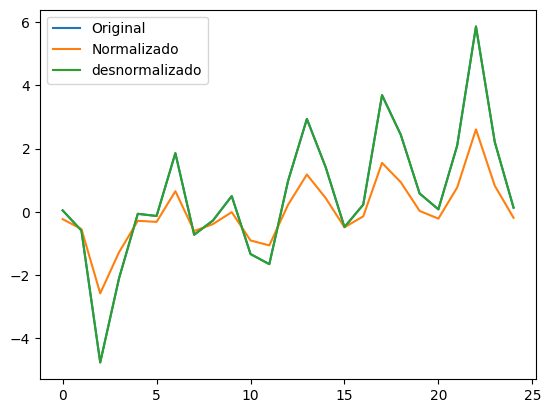

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...


remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 5.50 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-09-09 19:37:46.992544: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-09 19:37:47.049395: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 19:37:47.049437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 19:37:47.050652: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-09 19:37:47.059970: I tensorflow/core/platform/cpu_feature_guar

2024-09-09 19:37:51.529633: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [8]:
tester = Tester(
                _df=df_training_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[12, 2]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[12, 2], regularizer=0.02, learning_rate=0.01


+++++++++++ [1_0] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_0] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_0] | 3 ++++++++++++++++++

Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 245ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_0] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 38ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_0] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_0] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_0] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 1 ++++++++++++++++++


Stopped at epoch:  42
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 38ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_1] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_1] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_1] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_1] | 6 ++++++++++++++++++

Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_1] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


 1/32 [..............................] - ETA: 1s

12/32 [==========>...................] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_1] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_2] | 1 ++++++++++++++++++


Stopped at epoch:  32
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

20/32 [=================>............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_2] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_2] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_2] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_2] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_2] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 34ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_3] | 1 ++++++++++++++++++


Stopped at epoch:  20
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_3] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

11/32 [=========>....................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_3] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_3] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_3] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_3] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_4] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_4] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_4] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


 1/32 [..............................] - ETA: 1s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_4] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_9,0.900112,0.649684,0.664554,0.148037,0.419211,2.342566,1.199872,0.110871,0.549223,0.647465,1.058471,0.675029,131.738764,210.965692
model_1_4_8,0.898219,0.648143,0.663701,0.149332,0.427155,2.352867,1.202924,0.110702,0.554365,0.653571,1.059579,0.681395,131.701217,210.928145
model_1_4_7,0.896278,0.646587,0.662842,0.149063,0.435298,2.363271,1.205994,0.110738,0.559494,0.659771,1.060715,0.687859,131.663448,210.890377
model_1_4_6,0.894290,0.645018,0.661981,0.147357,0.443641,2.373765,1.209075,0.110960,0.564598,0.666064,1.061879,0.694420,131.625479,210.852408
model_1_4_5,0.892255,0.643437,0.661118,0.144354,0.452182,2.384336,1.212160,0.111350,0.569668,0.672445,1.063070,0.701073,131.587339,210.814267
model_1_4_4,0.890172,0.641847,0.660257,0.140174,0.460924,2.394972,1.215240,0.111894,0.574691,0.678914,1.064289,0.707816,131.549046,210.775974
model_1_4_3,0.888042,0.640249,0.659400,0.134929,0.469865,2.405660,1.218306,0.112577,0.579662,0.685467,1.065537,0.714649,131.510620,210.737549
model_1_4_2,0.885863,0.638645,0.658550,0.128741,0.479007,2.416386,1.221348,0.113382,0.584566,0.692103,1.066812,0.721567,131.472082,210.699011
model_1_4_1,0.883637,0.637037,0.657709,0.121711,0.488350,2.427138,1.224356,0.114297,0.589398,0.698820,1.068115,0.728570,131.433447,210.660376
model_1_4_0,0.881363,0.635427,0.656881,0.113948,0.497896,2.437903,1.227318,0.115307,0.594137,0.705617,1.069446,0.735657,131.394730,210.621658


DataFrame salvo em ../results/metrics_1_4


+++++++++++ [1_5] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 49ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_5] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_5] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 40ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

12/32 [==========>...................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_5] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 1s

 9/32 [=======>......................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_5] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_5] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_9,0.913053,0.660722,0.671745,0.902532,0.364900,2.268756,1.174149,0.645475,0.500777,0.604069,1.050896,0.629786,132.016266,211.243195
model_1_5_8,0.911889,0.659707,0.671076,0.902442,0.369784,2.275542,1.176541,0.646070,0.505058,0.608099,1.051577,0.633987,131.989673,211.216602
model_1_5_7,0.910698,0.658672,0.670396,0.902337,0.374782,2.282462,1.178973,0.646762,0.509377,0.612195,1.052274,0.638257,131.962820,211.189749
model_1_5_6,0.909479,0.657617,0.669705,0.902218,0.379899,2.289516,1.181446,0.647555,0.513735,0.616359,1.052988,0.642599,131.935702,211.162631
model_1_5_5,0.908231,0.656542,0.669002,0.902083,0.385135,2.296704,1.183960,0.648450,0.518132,0.620592,1.053718,0.647012,131.908325,211.135254
model_1_5_4,0.906954,0.655448,0.668288,0.901931,0.390493,2.304024,1.186513,0.649454,0.522572,0.624894,1.054466,0.651497,131.880692,211.107621
model_1_5_3,0.905648,0.654333,0.667563,0.901763,0.395976,2.311476,1.189108,0.650566,0.527422,0.629266,1.055231,0.656055,131.852804,211.079733
model_1_5_2,0.904311,0.653199,0.666827,0.901578,0.401586,2.319057,1.191741,0.651793,0.532790,0.633708,1.056013,0.660687,131.824665,211.051594
model_1_5_1,0.902943,0.652046,0.666080,0.901375,0.407327,2.326768,1.194414,0.653136,0.538211,0.638222,1.056814,0.665392,131.796276,211.023205
model_1_5_0,0.901543,0.650874,0.665322,0.901154,0.413201,2.334605,1.197124,0.654598,0.543689,0.642807,1.057633,0.670173,131.767640,210.994569


DataFrame salvo em ../results/metrics_1_5


+++++++++++ [1_6] | 1 ++++++++++++++++++


Stopped at epoch:  36
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_6] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 59ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_6] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 38ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_6] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_6] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 49ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 57ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_9,0.962330,0.694077,0.690190,0.962118,0.158093,2.045707,1.108173,0.255120,0.344789,0.397609,1.022051,0.414536,133.689148,212.916076
model_1_6_8,0.961628,0.693614,0.689986,0.961544,0.161038,2.048802,1.108902,0.258987,0.347603,0.401295,1.022461,0.418379,133.652233,212.879162
model_1_6_7,0.960905,0.693136,0.689771,0.960935,0.164074,2.052001,1.109669,0.263091,0.350448,0.405061,1.022885,0.422305,133.614874,212.841803
model_1_6_6,0.960159,0.692642,0.689545,0.960289,0.167204,2.055304,1.110478,0.267437,0.353328,0.408906,1.023322,0.426314,133.577083,212.804011
model_1_6_5,0.959391,0.692132,0.689307,0.959607,0.170429,2.058716,1.111330,0.272031,0.356242,0.412831,1.023771,0.430406,133.538870,212.765798
model_1_6_4,0.958599,0.691605,0.689057,0.958888,0.173751,2.062238,1.112224,0.276877,0.359187,0.416835,1.024235,0.434580,133.500261,212.727189
model_1_6_3,0.957784,0.691062,0.688796,0.958130,0.177172,2.065871,1.113160,0.281979,0.362169,0.420918,1.024712,0.438838,133.461265,212.688194
model_1_6_2,0.956945,0.690501,0.688521,0.957333,0.180695,2.069618,1.114141,0.287344,0.365187,0.425082,1.025203,0.443179,133.421894,212.648822
model_1_6_1,0.956081,0.689924,0.688235,0.956497,0.184319,2.073482,1.115165,0.292974,0.368240,0.429324,1.025709,0.447602,133.382170,212.609099
model_1_6_0,0.955192,0.689328,0.687936,0.955621,0.188049,2.077464,1.116235,0.298874,0.371329,0.433646,1.026229,0.452107,133.342107,212.569036


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 34ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_7] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_7] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

 9/32 [=======>......................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_7] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_7] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 36ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_9,0.967143,0.700119,0.696155,0.588159,0.137894,2.005307,1.086837,0.052243,0.355482,0.371341,1.019233,0.387150,133.962538,213.189467
model_1_7_8,0.966837,0.699624,0.695748,0.638874,0.139176,2.008614,1.088293,0.045809,0.344630,0.373063,1.019412,0.388945,133.944032,213.170961
model_1_7_7,0.966496,0.699106,0.695300,0.685621,0.140610,2.012079,1.089895,0.039879,0.334754,0.374980,1.019612,0.390944,133.923528,213.150457
model_1_7_6,0.966117,0.698564,0.694810,0.728255,0.142201,2.015707,1.091646,0.034471,0.326772,0.377096,1.019834,0.393150,133.901021,213.127950
model_1_7_5,0.965699,0.697997,0.694278,0.766619,0.143955,2.019497,1.093548,0.029605,0.318855,0.379414,1.020079,0.395566,133.876511,213.103440
model_1_7_4,0.965241,0.697406,0.693704,0.800574,0.145875,2.023450,1.095603,0.025298,0.311023,0.381936,1.020347,0.398196,133.850007,213.076935
model_1_7_3,0.964743,0.696790,0.693086,0.830025,0.147966,2.027570,1.097814,0.021562,0.307007,0.384663,1.020638,0.401039,133.821551,213.048480
model_1_7_2,0.964203,0.696149,0.692425,0.854873,0.150230,2.031856,1.100177,0.018410,0.314612,0.387596,1.020954,0.404096,133.791170,213.018099
model_1_7_1,0.963622,0.695483,0.691722,0.875062,0.152672,2.036308,1.102693,0.015849,0.324383,0.390732,1.021295,0.407367,133.758928,212.985857
model_1_7_0,0.962997,0.694792,0.690976,0.890558,0.155292,2.040925,1.105360,0.013883,0.334447,0.394071,1.021660,0.410848,133.724894,212.951822


DataFrame salvo em ../results/metrics_1_7


+++++++++++ [1_8] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


 1/32 [..............................] - ETA: 0s

11/32 [=========>....................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_8] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_8] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_8] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_8] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_9,0.971178,0.706238,0.699869,0.953523,0.120958,1.964389,1.073550,0.084891,0.318898,0.347790,1.016871,0.362596,134.224624,213.451553
model_1_8_8,0.970862,0.705683,0.699626,0.955643,0.122285,1.968096,1.074420,0.081019,0.322335,0.349693,1.017056,0.364580,134.202804,213.429733
model_1_8_7,0.970528,0.705118,0.699356,0.957665,0.123690,1.971877,1.075386,0.077326,0.325812,0.351695,1.017252,0.366668,134.179961,213.406889
model_1_8_6,0.970174,0.704541,0.699058,0.959589,0.125173,1.975736,1.076452,0.073813,0.329342,0.353799,1.017459,0.368861,134.156110,213.383038
model_1_8_5,0.969801,0.703951,0.698732,0.961411,0.126738,1.979678,1.077618,0.070483,0.332917,0.356003,1.017677,0.371159,134.131266,213.358195
model_1_8_4,0.969409,0.703349,0.698377,0.963134,0.128384,1.983707,1.078887,0.067338,0.336542,0.358308,1.017907,0.373562,134.105452,213.332380
model_1_8_3,0.968997,0.702733,0.697993,0.964753,0.130114,1.987827,1.080261,0.064379,0.340218,0.360713,1.018148,0.376069,134.078693,213.305622
model_1_8_2,0.968565,0.702102,0.697579,0.966269,0.131928,1.992042,1.081741,0.061610,0.343951,0.363218,1.018401,0.378681,134.051005,213.277933
model_1_8_1,0.968112,0.701457,0.697135,0.967679,0.133828,1.996357,1.083330,0.059035,0.347739,0.365825,1.018666,0.381399,134.022403,213.249332
model_1_8_0,0.967638,0.700796,0.696660,0.968982,0.135816,2.000777,1.085028,0.056656,0.351583,0.368533,1.018944,0.384222,133.992904,213.219833


DataFrame salvo em ../results/metrics_1_8


+++++++++++ [1_9] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_9] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_9] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_9] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

 9/32 [=======>......................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_9] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_9] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_9,0.972350,0.709887,0.712237,0.964764,0.116039,1.939987,1.029313,0.258345,0.282453,0.340646,1.016185,0.355148,134.307651,213.534580
model_1_9_8,0.972301,0.709552,0.711098,0.965511,0.116248,1.942230,1.033384,0.252869,0.285755,0.340952,1.016214,0.355467,134.304054,213.530983
model_1_9_7,0.972236,0.709210,0.709939,0.966234,0.116518,1.944516,1.037533,0.247565,0.289128,0.341347,1.016252,0.355879,134.299419,213.526348
model_1_9_6,0.972157,0.708861,0.708757,0.966934,0.116849,1.946845,1.041760,0.242435,0.292574,0.341832,1.016298,0.356385,134.293738,213.520667
model_1_9_5,0.972064,0.708507,0.707553,0.967610,0.117243,1.949218,1.046065,0.237479,0.296097,0.342408,1.016353,0.356985,134.287010,213.513939
model_1_9_4,0.971955,0.708145,0.706328,0.968262,0.117700,1.951635,1.050449,0.232699,0.299693,0.343074,1.016417,0.357680,134.279232,213.506161
model_1_9_3,0.971831,0.707777,0.705080,0.968890,0.118221,1.954096,1.054911,0.228097,0.303369,0.343833,1.016489,0.358470,134.270399,213.497328
model_1_9_2,0.971691,0.707402,0.703811,0.969493,0.118806,1.956601,1.059452,0.223670,0.307126,0.344683,1.016571,0.359357,134.260520,213.487449
model_1_9_1,0.971536,0.707021,0.702519,0.970073,0.119457,1.959152,1.064072,0.219422,0.310965,0.345626,1.016662,0.360340,134.249594,213.476523
model_1_9_0,0.971365,0.706633,0.701205,0.970628,0.120174,1.961747,1.068772,0.215354,0.314888,0.346662,1.016762,0.361420,134.237625,213.464553


DataFrame salvo em ../results/metrics_1_9


+++++++++++ [1_10] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_10] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 1s

10/32 [========>.....................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_10] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_9,0.976071,0.713250,0.716306,0.958235,0.100423,1.917501,1.014757,0.041968,0.350049,0.316896,1.014007,0.330387,134.596728,213.823656
model_1_10_8,0.975861,0.713008,0.716163,0.963076,0.101307,1.919115,1.015270,0.037103,0.337540,0.318288,1.014130,0.331838,134.579198,213.806126
model_1_10_7,0.975614,0.712746,0.715961,0.967352,0.102342,1.920867,1.015990,0.032807,0.325024,0.319910,1.014275,0.333529,134.558867,213.785796
model_1_10_6,0.975331,0.712463,0.715702,0.971064,0.103529,1.922759,1.016918,0.029076,0.312511,0.321759,1.014440,0.335457,134.535814,213.762743
model_1_10_5,0.975013,0.712159,0.715384,0.974215,0.104867,1.924792,1.018056,0.025910,0.300010,0.323832,1.014627,0.337618,134.510126,213.737055
model_1_10_4,0.974658,0.711834,0.715006,0.976811,0.106356,1.926967,1.019405,0.023302,0.287531,0.326123,1.014835,0.340007,134.481920,213.708849
model_1_10_3,0.974267,0.711487,0.714570,0.978857,0.107997,1.929285,1.020966,0.021245,0.275083,0.328628,1.015063,0.342619,134.451313,213.678241
model_1_10_2,0.973840,0.711119,0.714075,0.980364,0.109786,1.931746,1.022737,0.019731,0.267430,0.331340,1.015313,0.345446,134.418438,213.645367
model_1_10_1,0.973379,0.710730,0.713521,0.981341,0.111725,1.934349,1.024720,0.018749,0.270590,0.334252,1.015583,0.348482,134.383435,213.610363
model_1_10_0,0.972882,0.710319,0.712908,0.981803,0.113810,1.937097,1.026912,0.018285,0.276572,0.337357,1.015874,0.351719,134.346453,213.573381


DataFrame salvo em ../results/metrics_1_10


+++++++++++ [1_11] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 2s

12/32 [==========>...................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_11] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 38ms/step


 1/32 [..............................] - ETA: 1s

14/32 [============>.................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_11] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 1s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_9,0.978563,0.716106,0.727296,0.948362,0.089966,1.898403,0.975448,0.096938,0.338149,0.299943,1.012548,0.312712,134.816650,214.043579
model_1_11_8,0.978363,0.715870,0.726323,0.949950,0.090805,1.899977,0.978927,0.093957,0.339265,0.301338,1.012665,0.314167,134.798092,214.025020
model_1_11_7,0.978154,0.715625,0.725325,0.951505,0.091684,1.901618,0.982498,0.091037,0.340396,0.302794,1.012788,0.315685,134.778804,214.005733
model_1_11_6,0.977934,0.715369,0.724300,0.953025,0.092608,1.903328,0.986164,0.088185,0.341540,0.304315,1.012917,0.317271,134.758764,213.985693
model_1_11_5,0.977703,0.715102,0.723247,0.954505,0.093576,1.905111,0.989929,0.085405,0.342704,0.305901,1.013052,0.318924,134.737970,213.964898
model_1_11_4,0.977461,0.714825,0.722166,0.955945,0.094590,1.906970,0.993795,0.082703,0.343879,0.307555,1.013193,0.320648,134.716403,213.943331
model_1_11_3,0.977208,0.714535,0.721056,0.957340,0.095653,1.908907,0.997765,0.080084,0.345075,0.309278,1.013342,0.322445,134.694058,213.920986
model_1_11_2,0.976943,0.714233,0.719916,0.958688,0.096766,1.910925,1.001843,0.077554,0.346287,0.311072,1.013497,0.324315,134.670926,213.897854
model_1_11_1,0.976665,0.713918,0.718745,0.959985,0.097931,1.913029,1.006033,0.075119,0.347521,0.312939,1.013659,0.326261,134.646994,213.873922
model_1_11_0,0.976375,0.713591,0.717542,0.961228,0.099149,1.915219,1.010337,0.072785,0.348774,0.314879,1.013829,0.328284,134.622265,213.849193


DataFrame salvo em ../results/metrics_1_11


+++++++++++ [1_12] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_12] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_12] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 54ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_12] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_12] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_9,0.980267,0.721140,0.721558,0.980557,0.082815,1.864739,0.995971,0.143231,0.310938,0.287775,1.011551,0.300026,134.982303,214.209231
model_1_12_8,0.980187,0.720707,0.722207,0.981076,0.083151,1.867631,0.993650,0.139407,0.313032,0.288359,1.011598,0.300635,134.974198,214.201127
model_1_12_7,0.980088,0.720260,0.722841,0.981558,0.083565,1.870620,0.991383,0.135859,0.315151,0.289075,1.011656,0.301382,134.964270,214.191199
model_1_12_6,0.979971,0.719798,0.723459,0.982001,0.084058,1.873711,0.989170,0.132597,0.317295,0.289928,1.011724,0.302271,134.952492,214.179420
model_1_12_5,0.979834,0.719320,0.724062,0.982404,0.084634,1.876905,0.987015,0.129629,0.319460,0.290919,1.011805,0.303304,134.938837,214.165766
model_1_12_4,0.979676,0.718827,0.724647,0.982765,0.085295,1.880206,0.984921,0.126967,0.322019,0.292053,1.011897,0.304486,134.923285,214.150213
model_1_12_3,0.979498,0.718317,0.725215,0.983083,0.086043,1.883616,0.982889,0.124622,0.325013,0.293331,1.012001,0.305819,134.905811,214.132739
model_1_12_2,0.979298,0.717790,0.725765,0.983357,0.086882,1.887137,0.980924,0.122603,0.328247,0.294757,1.012118,0.307305,134.886416,214.113344
model_1_12_1,0.979076,0.717247,0.726295,0.983585,0.087813,1.890774,0.979026,0.120922,0.331517,0.296333,1.012248,0.308949,134.865086,214.092014
model_1_12_0,0.978831,0.716685,0.726806,0.983766,0.088840,1.894528,0.977201,0.119592,0.334814,0.298061,1.012391,0.310750,134.841832,214.068760


DataFrame salvo em ../results/metrics_1_12


+++++++++++ [1_13] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_13] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 1s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_13] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 49ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_13] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_13] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

12/32 [==========>...................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_9,0.979289,0.726159,0.719976,0.872390,0.086920,1.831177,1.001628,0.176125,0.305965,0.294822,1.012124,0.307373,134.885539,214.112467
model_1_13_8,0.979478,0.725712,0.720236,0.879076,0.086125,1.834163,1.000698,0.166896,0.301005,0.293470,1.012013,0.305964,134.903916,214.130845
model_1_13_7,0.979649,0.725254,0.720475,0.885553,0.085409,1.837227,0.999843,0.157957,0.296027,0.292248,1.011913,0.304689,134.920617,214.147545
model_1_13_6,0.979800,0.724784,0.720693,0.891812,0.084774,1.840372,0.999065,0.149318,0.291030,0.291160,1.011824,0.303556,134.935526,214.162454
model_1_13_5,0.979931,0.724301,0.720888,0.897849,0.084224,1.843599,0.998366,0.140986,0.286014,0.290213,1.011747,0.302568,134.948560,214.175489
model_1_13_4,0.980042,0.723806,0.721061,0.903655,0.083759,1.846908,0.997748,0.132973,0.280975,0.289412,1.011683,0.301733,134.959619,214.186548
model_1_13_3,0.980132,0.723299,0.721210,0.909224,0.083384,1.850302,0.997215,0.125287,0.275916,0.288762,1.011630,0.301055,134.968607,214.195536
model_1_13_2,0.980199,0.722779,0.721335,0.914548,0.083099,1.853781,0.996768,0.117939,0.283534,0.288269,1.011591,0.300541,134.975447,214.202376
model_1_13_1,0.980245,0.722245,0.721435,0.919621,0.082907,1.857346,0.996411,0.110937,0.292619,0.287937,1.011564,0.300195,134.980060,214.206989
model_1_13_0,0.980268,0.721699,0.721510,0.924436,0.082812,1.860999,0.996144,0.104292,0.301751,0.287770,1.011551,0.300021,134.982369,214.209298


DataFrame salvo em ../results/metrics_1_13


+++++++++++ [1_14] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_14] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_14] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_14] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_14] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_0,0.979614,0.726079,0.719766,0.992315,0.085554,1.831714,1.002383,0.021292,0.304971,0.292496,1.011933,0.304948,134.917215,214.144143
model_1_14_1,0.979929,0.725996,0.719552,0.991778,0.084233,1.832265,1.003146,0.022778,0.304015,0.290229,1.011749,0.302584,134.948343,214.175272
model_1_14_2,0.980234,0.725912,0.719336,0.991222,0.082955,1.832830,1.003919,0.024319,0.304110,0.288019,1.011571,0.300280,134.978918,214.205847
model_1_14_3,0.980528,0.725825,0.719117,0.990646,0.081719,1.833408,1.004701,0.025914,0.304393,0.285866,1.011398,0.298036,135.008933,214.235862
model_1_14_4,0.980813,0.725737,0.718897,0.990052,0.080525,1.834000,1.005491,0.027561,0.304701,0.283769,1.011232,0.295849,135.038386,214.265314
model_1_14_5,0.981088,0.725646,0.718673,0.989440,0.079371,1.834604,1.006289,0.029257,0.305030,0.281728,1.011071,0.293722,135.067256,214.294185
model_1_14_6,0.981353,0.725554,0.718448,0.988810,0.078256,1.835219,1.007096,0.031000,0.305380,0.279742,1.010915,0.291651,135.095552,214.322481
model_1_14_7,0.981610,0.725461,0.718220,0.988165,0.077179,1.835847,1.007911,0.032789,0.305752,0.277811,1.010765,0.289638,135.123255,214.350184
model_1_14_8,0.981858,0.725365,0.717990,0.987503,0.076140,1.836485,1.008733,0.034622,0.306139,0.275934,1.010620,0.287681,135.150373,214.377301
model_1_14_9,0.982097,0.725268,0.717758,0.986826,0.075137,1.837134,1.009564,0.036497,0.306549,0.274111,1.010480,0.285780,135.176889,214.403818


DataFrame salvo em ../results/metrics_1_14


+++++++++++ [1_15] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_15] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 34ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 36ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_0,0.982168,0.725049,0.717542,0.972236,0.074836,1.838599,1.010337,0.229431,0.304134,0.273562,1.010438,0.285208,135.184910,214.411839
model_1_15_1,0.982234,0.724829,0.717322,0.972055,0.074559,1.840068,1.011121,0.230932,0.301747,0.273056,1.010400,0.284680,135.192318,214.419246
model_1_15_2,0.982295,0.724609,0.717101,0.971866,0.074306,1.841541,1.011914,0.232491,0.299383,0.272591,1.010364,0.284196,135.199126,214.426055
model_1_15_3,0.982349,0.724388,0.716877,0.971671,0.074076,1.843016,1.012716,0.234108,0.297045,0.272168,1.010332,0.283755,135.205340,214.432269
model_1_15_4,0.982399,0.724167,0.716650,0.971468,0.073867,1.844494,1.013526,0.235781,0.294729,0.271785,1.010303,0.283356,135.210973,214.437901
model_1_15_5,0.982444,0.723946,0.716421,0.971259,0.073681,1.845974,1.014344,0.237508,0.292440,0.271442,1.010277,0.282997,135.216033,214.442961
model_1_15_6,0.982483,0.723724,0.716190,0.971044,0.073515,1.847456,1.015171,0.239287,0.290171,0.271136,1.010254,0.282679,135.220534,214.447462
model_1_15_7,0.982518,0.723503,0.715957,0.970822,0.073370,1.848939,1.016005,0.241118,0.287928,0.270869,1.010234,0.282400,135.224482,214.451410
model_1_15_8,0.982547,0.723281,0.715722,0.970595,0.073245,1.850423,1.016846,0.242997,0.285710,0.270638,1.010216,0.282160,135.227889,214.454817
model_1_15_9,0.982572,0.723059,0.715485,0.970362,0.073140,1.851908,1.017693,0.244924,0.283513,0.270443,1.010201,0.281957,135.230770,214.457698


DataFrame salvo em ../results/metrics_1_15


+++++++++++ [1_16] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_16] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_16] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_16] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_16] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 40ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_16] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_9,0.985087,0.724748,0.720979,0.993116,0.062588,1.840614,0.998043,0.043173,0.286779,0.250176,1.008730,0.260826,135.542364,214.769293
model_1_16_8,0.984869,0.724594,0.720476,0.993261,0.063501,1.841643,0.999842,0.042263,0.286228,0.251995,1.008857,0.262723,135.513389,214.740317
model_1_16_7,0.984644,0.724437,0.719963,0.993400,0.064445,1.842694,1.001677,0.041391,0.285702,0.253859,1.008989,0.264667,135.483897,214.710826
model_1_16_6,0.984412,0.724276,0.719440,0.993533,0.065418,1.843767,1.003548,0.040558,0.285204,0.255770,1.009125,0.266659,135.453901,214.680830
model_1_16_5,0.984173,0.724112,0.718906,0.993659,0.066423,1.844861,1.005457,0.039765,0.284733,0.257727,1.009265,0.268699,135.423414,214.650342
model_1_16_4,0.983926,0.723945,0.718362,0.993779,0.067460,1.845978,1.007401,0.039012,0.284290,0.259731,1.009409,0.270788,135.392438,214.619367
model_1_16_3,0.983671,0.723775,0.717808,0.993893,0.068529,1.847118,1.009383,0.038300,0.283975,0.261780,1.009558,0.272925,135.360997,214.587926
model_1_16_2,0.983409,0.723601,0.717244,0.994000,0.069631,1.848280,1.011403,0.037629,0.283813,0.263876,1.009712,0.275110,135.329098,214.556027
model_1_16_1,0.983138,0.723424,0.716668,0.994100,0.070766,1.849466,1.013461,0.037001,0.283682,0.266019,1.009870,0.277344,135.296753,214.523681
model_1_16_0,0.982859,0.723243,0.716082,0.994193,0.071935,1.850675,1.015557,0.036415,0.283582,0.268207,1.010033,0.279626,135.263978,214.490907


DataFrame salvo em ../results/metrics_1_16


+++++++++++ [1_17] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_17] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_17] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_17] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_17] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 1s

11/32 [=========>....................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 6ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_9,0.986283,0.725693,0.727724,0.950885,0.057567,1.834293,0.973914,0.103143,0.345511,0.239932,1.008029,0.250147,135.709597,214.936525
model_1_17_8,0.986196,0.725620,0.727118,0.951798,0.057934,1.834780,0.976085,0.101226,0.337719,0.240695,1.008081,0.250942,135.696898,214.923826
model_1_17_7,0.986101,0.725543,0.726496,0.952679,0.058329,1.835297,0.978307,0.099375,0.329905,0.241514,1.008136,0.251796,135.683307,214.910236
model_1_17_6,0.986000,0.725461,0.725860,0.953529,0.058753,1.835845,0.980582,0.097590,0.322068,0.242390,1.008195,0.252709,135.668826,214.895755
model_1_17_5,0.985892,0.725374,0.725209,0.954345,0.059207,1.836424,0.982911,0.095876,0.314214,0.243324,1.008258,0.253683,135.653440,214.880368
model_1_17_4,0.985777,0.725283,0.724543,0.955129,0.059691,1.837037,0.985293,0.094231,0.306338,0.244317,1.008326,0.254718,135.637162,214.864091
model_1_17_3,0.985654,0.725186,0.723862,0.955877,0.060205,1.837682,0.987730,0.092659,0.298443,0.245368,1.008397,0.255814,135.619986,214.846915
model_1_17_2,0.985524,0.725084,0.723165,0.956591,0.060752,1.838362,0.990223,0.091160,0.290533,0.246479,1.008474,0.256972,135.601919,214.828847
model_1_17_1,0.985386,0.724977,0.722452,0.957268,0.061331,1.839077,0.992772,0.089737,0.282606,0.247650,1.008554,0.258193,135.582952,214.809881
model_1_17_0,0.985241,0.724865,0.721724,0.957909,0.061942,1.839828,0.995378,0.088392,0.279104,0.248882,1.008640,0.259478,135.563099,214.790028


DataFrame salvo em ../results/metrics_1_17


+++++++++++ [1_18] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 33ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_18] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_18] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_18] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_18] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_18] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 37ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_9,0.987260,0.729782,0.731342,0.955722,0.053466,1.806949,0.960975,0.043858,0.432903,0.231228,1.007457,0.241072,135.857408,215.084336
model_1_18_8,0.987225,0.729422,0.731149,0.959525,0.053616,1.809358,0.961664,0.040091,0.424402,0.231551,1.007478,0.241409,135.851819,215.078747
model_1_18_7,0.987176,0.729051,0.730920,0.963145,0.053820,1.811840,0.962484,0.036505,0.415841,0.231991,1.007507,0.241868,135.844219,215.071148
model_1_18_6,0.987114,0.728668,0.730654,0.966579,0.054080,1.814396,0.963436,0.033104,0.407220,0.232551,1.007543,0.242451,135.834591,215.061519
model_1_18_5,0.987039,0.728275,0.730351,0.969820,0.054397,1.817026,0.964520,0.029894,0.398549,0.233231,1.007587,0.243160,135.822909,215.049837
model_1_18_4,0.986949,0.727871,0.730010,0.972864,0.054772,1.819728,0.965740,0.026878,0.389825,0.234034,1.007640,0.243997,135.809162,215.036090
model_1_18_3,0.986846,0.727456,0.729631,0.975708,0.055206,1.822501,0.967096,0.024062,0.381046,0.234960,1.007700,0.244963,135.793356,215.020285
model_1_18_2,0.986727,0.727031,0.729213,0.978345,0.055702,1.825346,0.968590,0.021449,0.372224,0.236012,1.007769,0.246060,135.775483,215.002412
model_1_18_1,0.986595,0.726595,0.728756,0.980773,0.056260,1.828260,0.970224,0.019045,0.363357,0.237191,1.007847,0.247289,135.755551,214.982480
model_1_18_0,0.986447,0.726149,0.728260,0.982985,0.056881,1.831243,0.971999,0.016853,0.354454,0.238498,1.007934,0.248651,135.733584,214.960513


DataFrame salvo em ../results/metrics_1_18


+++++++++++ [1_19] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_19] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_19] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_19] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

11/32 [=========>....................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_19] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_19] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_19] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_4,0.987723,0.729811,0.724306,0.967991,0.051523,1.806757,0.986141,0.035809,0.479642,0.226987,1.007186,0.236650,135.931456,215.158385
model_1_19_3,0.987655,0.729810,0.725716,0.970703,0.051810,1.806763,0.981098,0.032775,0.470663,0.227619,1.007227,0.237309,135.920326,215.147255
model_1_19_5,0.987781,0.729809,0.722897,0.965150,0.051282,1.806767,0.991180,0.038987,0.488422,0.226455,1.007153,0.236096,135.940835,215.167764
model_1_19_2,0.987575,0.729806,0.727126,0.973278,0.052147,1.806786,0.976055,0.029895,0.461494,0.228356,1.007273,0.238078,135.907392,215.134320
model_1_19_6,0.987827,0.729805,0.721491,0.962186,0.051086,1.806793,0.996211,0.042302,0.497000,0.226021,1.007125,0.235644,135.948502,215.175430
model_1_19_1,0.987482,0.729801,0.728534,0.975708,0.052533,1.806824,0.971016,0.027175,0.452137,0.229202,1.007327,0.238959,135.892612,215.119540
model_1_19_7,0.987864,0.729799,0.720087,0.959106,0.050932,1.806835,1.001231,0.045749,0.505382,0.225682,1.007104,0.235289,135.954519,215.181448
model_1_19_0,0.987378,0.729793,0.729940,0.977988,0.052973,1.806879,0.965989,0.024625,0.442600,0.230158,1.007389,0.239956,135.875960,215.102889
model_1_19_8,0.987891,0.729790,0.718688,0.955918,0.050820,1.806893,1.006237,0.049315,0.513553,0.225432,1.007088,0.235029,135.958944,215.185873
model_1_19_9,0.987908,0.729779,0.717293,0.952628,0.050746,1.806967,1.011225,0.052996,0.521523,0.225269,1.007078,0.234859,135.961837,215.188766


DataFrame salvo em ../results/metrics_1_19


+++++++++++ [1_20] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_20] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

 8/32 [======>.......................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_20] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_20] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_20] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_20] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_20] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 1s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_20_0,0.987914,0.729535,0.715677,0.951803,0.050723,1.808599,1.017006,0.051130,0.527778,0.225217,1.007075,0.234805,135.962758,215.189687
model_1_20_1,0.987903,0.729280,0.714041,0.947806,0.050769,1.810304,1.022860,0.055369,0.534217,0.225320,1.007081,0.234913,135.960930,215.187859
model_1_20_2,0.987875,0.729015,0.712385,0.943559,0.050885,1.812079,1.028783,0.059875,0.541178,0.225576,1.007097,0.235179,135.956392,215.183321
model_1_20_3,0.987832,0.728739,0.710710,0.939062,0.051068,1.813924,1.034774,0.064645,0.548476,0.225982,1.007123,0.235603,135.949192,215.176121
model_1_20_4,0.987772,0.728453,0.709016,0.934319,0.051319,1.815836,1.040831,0.069677,0.555936,0.226538,1.007158,0.236182,135.939370,215.166298
model_1_20_5,0.987696,0.728157,0.707305,0.929329,0.051638,1.817816,1.046953,0.074970,0.563554,0.227239,1.007202,0.236913,135.927004,215.153933
model_1_20_6,0.987604,0.727851,0.705576,0.924096,0.052023,1.819859,1.053138,0.080521,0.571320,0.228084,1.007256,0.237794,135.912157,215.139086
model_1_20_7,0.987497,0.727536,0.703830,0.918621,0.052473,1.821966,1.059383,0.086330,0.579232,0.229069,1.007319,0.238821,135.894921,215.121850
model_1_20_8,0.987374,0.727212,0.702067,0.912905,0.052988,1.824135,1.065688,0.092394,0.587286,0.230192,1.007391,0.239991,135.875374,215.102303
model_1_20_9,0.987236,0.726879,0.700289,0.906950,0.053568,1.826363,1.072049,0.098711,0.595481,0.231448,1.007472,0.241301,135.853596,215.080525


DataFrame salvo em ../results/metrics_1_20
+++++++++++ [1_21] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_21] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_21] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_1,0.987638,0.726887,0.701642,0.996471,0.051880,1.826309,1.067208,0.025004,0.577910,0.227773,1.007236,0.237470,135.917625,215.144554
model_1_21_2,0.987825,0.726885,0.702287,0.996366,0.051096,1.826321,1.064901,0.025747,0.569239,0.226045,1.007127,0.235668,135.948087,215.175015
model_1_21_0,0.987442,0.726885,0.700976,0.996561,0.052704,1.826323,1.069590,0.024365,0.586657,0.229574,1.007351,0.239347,135.886123,215.113052
model_1_21_3,0.988003,0.726879,0.702912,0.996247,0.050351,1.826360,1.062666,0.026589,0.560651,0.224390,1.007023,0.233942,135.977487,215.204416
model_1_21_4,0.988171,0.726870,0.703517,0.996115,0.049643,1.826423,1.060503,0.027528,0.552139,0.222806,1.006924,0.232291,136.005812,215.232741
model_1_21_5,0.988331,0.726857,0.704102,0.995969,0.048971,1.826511,1.058409,0.028561,0.543700,0.221294,1.006830,0.230715,136.033054,215.259983
model_1_21_6,0.988483,0.726840,0.704668,0.995810,0.048335,1.826622,1.056384,0.029685,0.535341,0.219853,1.006742,0.229212,136.059190,215.286119
model_1_21_7,0.988626,0.726820,0.705216,0.995639,0.047734,1.826756,1.054424,0.030897,0.528659,0.218482,1.006658,0.227783,136.084215,215.311143
model_1_21_8,0.988761,0.726797,0.705746,0.995456,0.047167,1.826913,1.052530,0.032194,0.525660,0.217179,1.006579,0.226425,136.108125,215.335053
model_1_21_9,0.988889,0.726770,0.706258,0.995261,0.046632,1.827090,1.050699,0.033574,0.522695,0.215946,1.006504,0.225139,136.130917,215.357845


DataFrame salvo em ../results/metrics_1_21
+++++++++++ [1_22] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 41ms/step


 1/32 [..............................] - ETA: 1s

 9/32 [=======>......................] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 1s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_22] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 49ms/step


 1/32 [..............................] - ETA: 0s

 7/32 [=====>........................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_22] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_22] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_22] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_22] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_9,0.988755,0.727936,0.706881,0.904545,0.047191,1.819294,1.048471,0.083219,0.477246,0.217235,1.006582,0.226483,136.107101,215.334030
model_1_22_8,0.988806,0.727847,0.706876,0.909304,0.046980,1.819887,1.048486,0.079070,0.481606,0.216750,1.006553,0.225977,136.116049,215.342977
model_1_22_7,0.988849,0.727753,0.706861,0.913962,0.046800,1.820516,1.048540,0.075009,0.486007,0.216332,1.006528,0.225542,136.123762,215.350691
model_1_22_6,0.988884,0.727653,0.706834,0.918513,0.046650,1.821186,1.048638,0.071042,0.490445,0.215987,1.006507,0.225182,136.130154,215.357083
model_1_22_5,0.988912,0.727547,0.706794,0.922948,0.046534,1.821895,1.048781,0.067175,0.494925,0.215718,1.006491,0.224901,136.135138,215.362066
model_1_22_4,0.988931,0.727435,0.706741,0.927259,0.046453,1.822646,1.048972,0.063416,0.499444,0.215529,1.006479,0.224705,136.138638,215.365566
model_1_22_3,0.988942,0.727316,0.706674,0.931439,0.046408,1.823441,1.049210,0.059772,0.504009,0.215425,1.006473,0.224596,136.140566,215.367495
model_1_22_2,0.988944,0.727190,0.706593,0.935478,0.046401,1.824281,1.049500,0.056252,0.508613,0.215410,1.006472,0.224580,136.140848,215.367776
model_1_22_1,0.988935,0.727057,0.706497,0.939365,0.046435,1.825168,1.049843,0.052862,0.513262,0.215489,1.006477,0.224663,136.139383,215.366312
model_1_22_0,0.988917,0.726917,0.706385,0.943092,0.046512,1.826104,1.050242,0.049614,0.517954,0.215666,1.006487,0.224848,136.136095,215.363023


DataFrame salvo em ../results/metrics_1_22
+++++++++++ [1_23] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_23] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 41ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_23] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 1s

11/32 [=========>....................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_23] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_23] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_9,0.988389,0.730636,0.708978,0.944149,0.048731,1.801237,1.040968,0.139958,0.444180,0.220751,1.006797,0.230149,136.042881,215.269810
model_1_23_8,0.988445,0.730387,0.708840,0.945463,0.048493,1.802904,1.041464,0.136664,0.447395,0.220210,1.006764,0.229585,136.052690,215.279619
model_1_23_7,0.988498,0.730133,0.708686,0.946761,0.048271,1.804601,1.042013,0.133413,0.450633,0.219707,1.006733,0.229060,136.061849,215.288778
model_1_23_6,0.988547,0.729875,0.708518,0.948041,0.048067,1.806326,1.042613,0.130205,0.453889,0.219242,1.006704,0.228575,136.070323,215.297252
model_1_23_5,0.988591,0.729612,0.708335,0.949302,0.047881,1.808083,1.043269,0.127044,0.457169,0.218818,1.006678,0.228133,136.078067,215.304996
model_1_23_4,0.988631,0.729345,0.708136,0.950543,0.047714,1.809869,1.043982,0.123934,0.460465,0.218436,1.006655,0.227735,136.085049,215.311977
model_1_23_3,0.988666,0.729073,0.707920,0.951764,0.047567,1.811688,1.044755,0.120875,0.463782,0.218099,1.006635,0.227384,136.091224,215.318152
model_1_23_2,0.988696,0.728796,0.707687,0.952962,0.047440,1.813539,1.045587,0.117872,0.467119,0.217808,1.006617,0.227081,136.096561,215.323489
model_1_23_1,0.988721,0.728515,0.707437,0.954138,0.047335,1.815423,1.046482,0.114927,0.470476,0.217566,1.006602,0.226828,136.101014,215.327943
model_1_23_0,0.988741,0.728228,0.707168,0.955288,0.047252,1.817342,1.047443,0.112043,0.473852,0.217374,1.006591,0.226628,136.104538,215.331467


DataFrame salvo em ../results/metrics_1_23


+++++++++++ [1_24] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 1s

11/32 [=========>....................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_24] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_24] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_24] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_24] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 34ms/step


 1/32 [..............................] - ETA: 1s

10/32 [========>.....................] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_0,0.988416,0.730524,0.708943,0.981127,0.048617,1.801988,1.041093,0.126817,0.440059,0.220493,1.006781,0.229880,136.047554,215.274483
model_1_24_1,0.988439,0.730413,0.708907,0.980857,0.048517,1.802728,1.041221,0.128634,0.435978,0.220266,1.006767,0.229644,136.051671,215.278600
model_1_24_2,0.988460,0.730304,0.708871,0.980583,0.048431,1.803458,1.041352,0.130471,0.431934,0.220070,1.006755,0.229439,136.055238,215.282167
model_1_24_3,0.988478,0.730196,0.708833,0.980307,0.048357,1.804179,1.041486,0.132328,0.427936,0.219903,1.006745,0.229264,136.058280,215.285208
model_1_24_4,0.988492,0.730090,0.708794,0.980028,0.048296,1.804890,1.041625,0.134204,0.423972,0.219764,1.006736,0.229120,136.060796,215.287724
model_1_24_5,0.988504,0.729985,0.708755,0.979746,0.048248,1.805592,1.041768,0.136097,0.420050,0.219654,1.006730,0.229005,136.062815,215.289744
model_1_24_6,0.988512,0.729881,0.708714,0.979462,0.048211,1.806285,1.041913,0.138007,0.416169,0.219570,1.006724,0.228917,136.064339,215.291267
model_1_24_7,0.988518,0.729779,0.708673,0.979175,0.048186,1.806969,1.042061,0.139933,0.412323,0.219512,1.006721,0.228857,136.065393,215.292322
model_1_24_8,0.988522,0.729678,0.708630,0.978886,0.048171,1.807645,1.042214,0.141873,0.408521,0.219479,1.006719,0.228823,136.065988,215.292917
model_1_24_9,0.988523,0.729578,0.708587,0.978596,0.048168,1.808313,1.042369,0.143827,0.404754,0.219471,1.006718,0.228814,136.066138,215.293067


DataFrame salvo em ../results/metrics_1_24


+++++++++++ [1_25] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 45ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_25] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_25] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_25] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 1s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_9,0.990086,0.730759,0.711833,0.970700,0.041608,1.800416,1.030757,0.026102,0.418625,0.203981,1.005803,0.212664,136.358923,215.585851
model_1_25_8,0.989974,0.730641,0.711577,0.972201,0.042079,1.801204,1.031671,0.024766,0.417843,0.205131,1.005869,0.213864,136.336426,215.563355
model_1_25_7,0.989852,0.730523,0.711307,0.973555,0.042590,1.801994,1.032638,0.023559,0.416933,0.206375,1.005940,0.215160,136.312250,215.539179
model_1_25_6,0.989720,0.730405,0.711022,0.974765,0.043143,1.802785,1.033659,0.022481,0.415889,0.207709,1.006018,0.216552,136.286470,215.513399
model_1_25_5,0.989578,0.730286,0.710721,0.975832,0.043737,1.803577,1.034736,0.021531,0.414711,0.209134,1.006100,0.218037,136.259123,215.486052
model_1_25_4,0.989427,0.730168,0.710404,0.976755,0.044372,1.804369,1.035867,0.020708,0.413394,0.210647,1.006189,0.219614,136.230295,215.457223
model_1_25_3,0.989266,0.730050,0.710072,0.977538,0.045048,1.805160,1.037054,0.020011,0.411935,0.212246,1.006283,0.221282,136.200040,215.426969
model_1_25_2,0.989095,0.729931,0.709725,0.978182,0.045766,1.805951,1.038298,0.019437,0.410334,0.213930,1.006383,0.223038,136.168423,215.395352
model_1_25_1,0.988914,0.729813,0.709361,0.978688,0.046525,1.806740,1.039598,0.018987,0.408586,0.215697,1.006489,0.224880,136.135519,215.362448
model_1_25_0,0.988723,0.729695,0.708982,0.979058,0.047326,1.807528,1.040954,0.018657,0.406686,0.217544,1.006601,0.226806,136.101409,215.328338


DataFrame salvo em ../results/metrics_1_25


+++++++++++ [1_26] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 34ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 1s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_26] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 52ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 54ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_0,0.990207,0.730564,0.711849,0.997042,0.041100,1.801720,1.030698,0.022197,0.414965,0.202731,1.005733,0.211362,136.383494,215.610423
model_1_26_1,0.990323,0.730369,0.711862,0.996881,0.040612,1.803025,1.030654,0.023406,0.411327,0.201524,1.005665,0.210103,136.407383,215.634312
model_1_26_2,0.990435,0.730173,0.711870,0.996716,0.040144,1.804333,1.030625,0.024641,0.407715,0.200359,1.005599,0.208889,136.430580,215.657508
model_1_26_3,0.990542,0.729977,0.711873,0.996548,0.039695,1.805643,1.030612,0.025901,0.404126,0.199235,1.005537,0.207717,136.453073,215.680001
model_1_26_4,0.990644,0.729781,0.711873,0.996377,0.039264,1.806954,1.030614,0.027186,0.400559,0.198153,1.005477,0.206588,136.474872,215.701800
model_1_26_5,0.990742,0.729585,0.711868,0.996203,0.038852,1.808265,1.030630,0.028493,0.397021,0.197110,1.005419,0.205502,136.495969,215.722898
model_1_26_6,0.990836,0.729389,0.711860,0.996025,0.038458,1.809578,1.030660,0.029822,0.393504,0.196108,1.005364,0.204457,136.516353,215.743282
model_1_26_7,0.990926,0.729193,0.711848,0.995845,0.038082,1.810891,1.030704,0.031173,0.390013,0.195146,1.005312,0.203453,136.536037,215.762966
model_1_26_8,0.991012,0.728996,0.711832,0.995663,0.037722,1.812204,1.030760,0.032545,0.386544,0.194222,1.005261,0.202491,136.555011,215.781940
model_1_26_9,0.991093,0.728800,0.711813,0.995477,0.037379,1.813517,1.030830,0.033937,0.383104,0.193337,1.005214,0.201568,136.573276,215.800204


DataFrame salvo em ../results/metrics_1_26


+++++++++++ [1_27] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_27] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

10/32 [========>.....................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_27] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_0,0.991204,0.728236,0.711512,0.976376,0.036915,1.817286,1.031905,0.015168,0.378415,0.192132,1.005149,0.200311,136.598291,215.825220
model_1_27_1,0.991295,0.727667,0.711189,0.974109,0.036531,1.821092,1.033060,0.016624,0.375012,0.191131,1.005095,0.199268,136.619183,215.846112
model_1_27_2,0.991368,0.727093,0.710844,0.971340,0.036225,1.824932,1.034293,0.018402,0.374336,0.190330,1.005053,0.198433,136.635987,215.862915
model_1_27_3,0.991423,0.726514,0.710479,0.968089,0.035995,1.828805,1.035601,0.020490,0.373666,0.189723,1.005021,0.197800,136.648758,215.875686
model_1_27_4,0.991461,0.725930,0.710093,0.964375,0.035836,1.832708,1.036982,0.022874,0.372993,0.189305,1.004998,0.197364,136.657579,215.884508
model_1_27_5,0.991482,0.725342,0.709688,0.960217,0.035748,1.836639,1.038431,0.025544,0.372323,0.189071,1.004986,0.197120,136.662530,215.889459
model_1_27_6,0.991487,0.724750,0.709264,0.955634,0.035726,1.840596,1.039947,0.028486,0.371652,0.189013,1.004983,0.197060,136.663753,215.890682
model_1_27_7,0.991477,0.724155,0.708823,0.950645,0.035769,1.844575,1.041525,0.031690,0.370983,0.189126,1.004989,0.197178,136.661366,215.888294
model_1_27_8,0.991452,0.723557,0.708364,0.945268,0.035873,1.848576,1.043164,0.035142,0.370315,0.189402,1.005004,0.197465,136.655540,215.882469
model_1_27_9,0.991413,0.722956,0.707890,0.939518,0.036037,1.852595,1.044862,0.038834,0.369648,0.189834,1.005026,0.197916,136.646422,215.873351


DataFrame salvo em ../results/metrics_1_27


+++++++++++ [1_28] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_28] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_28] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

12/32 [==========>...................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_28] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_28] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_28] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_28] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_0,0.991477,0.722800,0.708321,0.995921,0.035770,1.853635,1.043320,0.027122,0.366797,0.189129,1.004989,0.197181,136.661299,215.888228
model_1_28_1,0.991532,0.722645,0.708740,0.995639,0.035536,1.854675,1.041820,0.028992,0.363982,0.188511,1.004957,0.196537,136.674390,215.901319
model_1_28_2,0.991580,0.722490,0.709147,0.995342,0.035337,1.855714,1.040363,0.030968,0.361167,0.187980,1.004929,0.195983,136.685672,215.912600
model_1_28_3,0.991620,0.722334,0.709543,0.995029,0.035170,1.856751,1.038949,0.033048,0.358358,0.187536,1.004905,0.195519,136.695148,215.922076
model_1_28_4,0.991652,0.722179,0.709926,0.994701,0.035034,1.857787,1.037578,0.035231,0.355564,0.187175,1.004887,0.195143,136.702845,215.929774
model_1_28_5,0.991677,0.722025,0.710298,0.994358,0.034931,1.858822,1.036249,0.037513,0.352798,0.186898,1.004872,0.194854,136.708772,215.935701
model_1_28_6,0.991694,0.721870,0.710657,0.994000,0.034858,1.859856,1.034962,0.039893,0.350072,0.186702,1.004862,0.194651,136.712961,215.939889
model_1_28_7,0.991704,0.721716,0.711005,0.993628,0.034815,1.860887,1.033718,0.042366,0.347385,0.186587,1.004856,0.194530,136.715437,215.942365
model_1_28_8,0.991708,0.721562,0.711341,0.993242,0.034801,1.861917,1.032516,0.044932,0.344751,0.186549,1.004854,0.194491,136.716246,215.943174
model_1_28_9,0.991704,0.721408,0.711666,0.992843,0.034815,1.862945,1.031355,0.047585,0.342174,0.186587,1.004856,0.194530,136.715439,215.942368


DataFrame salvo em ../results/metrics_1_28


+++++++++++ [1_29] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_29] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 36ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_29] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_29] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_2,0.992141,0.721419,0.712207,0.982670,0.032981,1.862872,1.029420,0.013882,0.343336,0.181608,1.004600,0.189339,136.823620,216.050548
model_1_29_3,0.992274,0.721418,0.712369,0.982399,0.032424,1.862876,1.028839,0.014099,0.343726,0.180065,1.004522,0.187731,136.857742,216.084671
model_1_29_1,0.992002,0.721418,0.712035,0.982854,0.033566,1.862882,1.030033,0.013735,0.342945,0.183209,1.004682,0.191009,136.788511,216.015439
model_1_29_4,0.992401,0.721416,0.712523,0.982043,0.031891,1.862893,1.028287,0.014384,0.344118,0.178581,1.004448,0.186184,136.890848,216.117777
model_1_29_0,0.991857,0.721414,0.711855,0.982948,0.034176,1.862906,1.030678,0.013659,0.342559,0.184868,1.004767,0.192739,136.752444,215.979372
model_1_29_5,0.992522,0.721411,0.712669,0.981604,0.031384,1.862923,1.027766,0.014736,0.344506,0.177155,1.004377,0.184697,136.922915,216.149844
model_1_29_6,0.992637,0.721405,0.712807,0.981084,0.030901,1.862966,1.027274,0.015152,0.344901,0.175787,1.004310,0.183271,136.953921,216.180850
model_1_29_7,0.992746,0.721397,0.712936,0.980486,0.030442,1.863021,1.026810,0.015632,0.345292,0.174477,1.004246,0.181905,136.983847,216.210775
model_1_29_8,0.992850,0.721387,0.713058,0.979811,0.030007,1.863087,1.026375,0.016173,0.345683,0.173224,1.004185,0.180599,137.012671,216.239600
model_1_29_9,0.992948,0.721375,0.713172,0.979061,0.029594,1.863166,1.025966,0.016773,0.346073,0.172028,1.004128,0.179352,137.040382,216.267310


DataFrame salvo em ../results/metrics_1_29
+++++++++++ [1_30] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 49ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_30] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_30] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_30] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_30] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_0,0.992962,0.721029,0.713306,0.990710,0.029539,1.865483,1.025486,0.036860,0.345608,0.171868,1.004120,0.179185,137.044105,216.271034
model_1_30_1,0.992967,0.720684,0.713428,0.990183,0.029514,1.867791,1.025051,0.038951,0.345132,0.171797,1.004117,0.179110,137.045778,216.272707
model_1_30_2,0.992966,0.720340,0.713538,0.989631,0.029518,1.870088,1.024659,0.041144,0.344641,0.171809,1.004117,0.179124,137.045477,216.272405
model_1_30_3,0.992959,0.719998,0.713637,0.989054,0.029551,1.872375,1.024305,0.043434,0.344138,0.171904,1.004122,0.179222,137.043275,216.270203
model_1_30_4,0.992945,0.719658,0.713724,0.988454,0.029610,1.874651,1.023993,0.045813,0.343621,0.172076,1.004130,0.179402,137.039275,216.266204
model_1_30_5,0.992924,0.719319,0.713801,0.987832,0.029695,1.876917,1.023716,0.048282,0.343097,0.172323,1.004142,0.179659,137.033532,216.260460
model_1_30_6,0.992898,0.718982,0.713869,0.987189,0.029805,1.879170,1.023475,0.050832,0.342560,0.172641,1.004157,0.179991,137.026160,216.253088
model_1_30_7,0.992866,0.718647,0.713927,0.986527,0.029938,1.881412,1.023268,0.053460,0.342007,0.173027,1.004176,0.180393,137.017227,216.244155
model_1_30_8,0.992829,0.718313,0.713975,0.985846,0.030094,1.883642,1.023094,0.056162,0.341447,0.173477,1.004198,0.180862,137.006847,216.233776
model_1_30_9,0.992787,0.717981,0.714015,0.985147,0.030272,1.885859,1.022950,0.058935,0.340877,0.173989,1.004222,0.181396,136.995057,216.221985


DataFrame salvo em ../results/metrics_1_30


+++++++++++ [1_31] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_31] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_31] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 35ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_31] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_31] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_31] | 7 ++++++++++++++++++

Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_31] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_31] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_0,0.992864,0.717925,0.712957,0.991259,0.029947,1.886236,1.026736,0.020447,0.339414,0.173051,1.004177,0.180418,137.016672,216.243600
model_1_31_1,0.992937,0.717867,0.711907,0.990813,0.029641,1.886627,1.030490,0.021491,0.337976,0.172166,1.004134,0.179496,137.037174,216.264103
model_1_31_2,0.993005,0.717806,0.710866,0.990347,0.029355,1.887034,1.034215,0.022580,0.336560,0.171334,1.004094,0.178628,137.056564,216.283493
model_1_31_3,0.993069,0.717743,0.709833,0.989862,0.029088,1.887456,1.037910,0.023714,0.335166,0.170552,1.004057,0.177812,137.074869,216.301798
model_1_31_4,0.993128,0.717678,0.708808,0.989360,0.028839,1.887891,1.041575,0.024889,0.333794,0.169820,1.004022,0.177050,137.092055,216.318984
model_1_31_5,0.993183,0.717610,0.707792,0.988840,0.028608,1.888341,1.045210,0.026105,0.332444,0.169138,1.003990,0.176338,137.108163,216.335091
model_1_31_6,0.993234,0.717541,0.706784,0.988304,0.028393,1.888803,1.048816,0.027359,0.331117,0.168504,1.003960,0.175677,137.123192,216.350120
model_1_31_7,0.993282,0.717470,0.705784,0.987752,0.028196,1.889278,1.052392,0.028651,0.329810,0.167917,1.003933,0.175065,137.137147,216.364075
model_1_31_8,0.993325,0.717397,0.704793,0.987184,0.028015,1.889765,1.055939,0.029978,0.328522,0.167376,1.003907,0.174502,137.150050,216.376978
model_1_31_9,0.993364,0.717323,0.703809,0.986602,0.027849,1.890263,1.059457,0.031339,0.327254,0.166880,1.003884,0.173985,137.161917,216.388846


DataFrame salvo em ../results/metrics_1_31


+++++++++++ [1_32] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 63ms/step


 1/32 [..............................] - ETA: 0s

11/32 [=========>....................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_32] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_9,0.993595,0.719241,0.707551,0.994063,0.026880,1.877435,1.046072,0.048528,0.299731,0.163951,1.003749,0.170931,137.232755,216.459683
model_1_32_8,0.993582,0.719062,0.707205,0.994244,0.026933,1.878634,1.047312,0.047052,0.302361,0.164114,1.003757,0.171101,137.228774,216.455702
model_1_32_7,0.993567,0.718880,0.706852,0.994423,0.026996,1.879852,1.048573,0.045585,0.305017,0.164304,1.003765,0.171299,137.224136,216.451064
model_1_32_6,0.993550,0.718695,0.706494,0.994602,0.027067,1.881087,1.049855,0.044127,0.307701,0.164522,1.003775,0.171526,137.218850,216.445779
model_1_32_5,0.993531,0.718508,0.706129,0.994779,0.027148,1.882340,1.051158,0.042680,0.310409,0.164768,1.003787,0.171782,137.212872,216.439801
model_1_32_4,0.993509,0.718317,0.705759,0.994954,0.027239,1.883612,1.052484,0.041243,0.313149,0.165043,1.003799,0.172069,137.206193,216.433122
model_1_32_3,0.993485,0.718125,0.705382,0.995129,0.027340,1.884903,1.053832,0.039819,0.315912,0.165348,1.003813,0.172387,137.198811,216.425740
model_1_32_2,0.993459,0.717929,0.704999,0.995301,0.027451,1.886213,1.055203,0.038406,0.318706,0.165683,1.003829,0.172737,137.190707,216.417636
model_1_32_1,0.993430,0.717730,0.704609,0.995473,0.027573,1.887543,1.056598,0.037007,0.321527,0.166050,1.003846,0.173119,137.181867,216.408796
model_1_32_0,0.993398,0.717528,0.704212,0.995642,0.027705,1.888893,1.058015,0.035622,0.324378,0.166449,1.003864,0.173535,137.172266,216.399194


DataFrame salvo em ../results/metrics_1_32
+++++++++++ [1_33] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_33] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_33] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

12/32 [==========>...................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_33] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_33] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_33] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_0,0.993569,0.718980,0.707591,0.990220,0.026989,1.879185,1.045931,0.051352,0.296513,0.164283,1.003764,0.171277,137.224661,216.451589
model_1_33_1,0.993540,0.718720,0.707625,0.989784,0.027113,1.880923,1.045807,0.053643,0.293368,0.164660,1.003782,0.171670,137.215497,216.442425
model_1_33_2,0.993507,0.718461,0.707656,0.989340,0.027251,1.882652,1.045697,0.055972,0.290297,0.165079,1.003801,0.172107,137.205329,216.432257
model_1_33_3,0.993471,0.718204,0.707682,0.988890,0.027403,1.884370,1.045604,0.058337,0.287294,0.165538,1.003822,0.172585,137.194219,216.421148
model_1_33_4,0.993431,0.717949,0.707704,0.988433,0.027568,1.886077,1.045526,0.060734,0.284361,0.166035,1.003845,0.173103,137.182229,216.409158
model_1_33_5,0.993389,0.717695,0.707722,0.987971,0.027745,1.887774,1.045462,0.063161,0.281493,0.166567,1.003870,0.173658,137.169426,216.396355
model_1_33_6,0.993344,0.717443,0.707736,0.987503,0.027933,1.889459,1.045411,0.065616,0.278687,0.167133,1.003896,0.174248,137.155871,216.382799
model_1_33_7,0.993296,0.717193,0.707746,0.987031,0.028133,1.891134,1.045374,0.068096,0.275947,0.167730,1.003924,0.174870,137.141608,216.368537
model_1_33_8,0.993246,0.716944,0.707754,0.986554,0.028344,1.892798,1.045349,0.070599,0.273269,0.168356,1.003953,0.175523,137.126702,216.353631
model_1_33_9,0.993194,0.716697,0.707757,0.986074,0.028564,1.894451,1.045337,0.073123,0.270647,0.169009,1.003984,0.176204,137.111212,216.338140


DataFrame salvo em ../results/metrics_1_33
+++++++++++ [1_34] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 56ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_34] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_34] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 1s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 6 ++++++++++++++++++

Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_34] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_34] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_0,0.993290,0.716687,0.707722,0.995965,0.028162,1.894516,1.045461,0.011049,0.272074,0.167817,1.003928,0.174961,137.139531,216.366459
model_1_34_1,0.993380,0.716675,0.707681,0.995719,0.027781,1.894594,1.045607,0.011724,0.273497,0.166678,1.003875,0.173773,137.166778,216.393706
model_1_34_2,0.993466,0.716662,0.707635,0.995455,0.027420,1.894683,1.045774,0.012447,0.274919,0.165590,1.003825,0.172640,137.192960,216.419889
model_1_34_3,0.993548,0.716647,0.707581,0.995174,0.027078,1.894784,1.045964,0.013215,0.276340,0.164554,1.003777,0.171559,137.218064,216.444993
model_1_34_4,0.993625,0.716630,0.707523,0.994877,0.026755,1.894896,1.046173,0.014029,0.277754,0.163569,1.003732,0.170532,137.242086,216.469014
model_1_34_5,0.993698,0.716612,0.707459,0.994564,0.026450,1.895018,1.046402,0.014885,0.279165,0.162634,1.003689,0.169558,137.265012,216.491941
model_1_34_6,0.993766,0.716592,0.707390,0.994236,0.026163,1.895151,1.046650,0.015784,0.280577,0.161749,1.003649,0.168635,137.286831,216.513760
model_1_34_7,0.993830,0.716571,0.707315,0.993894,0.025893,1.895293,1.046916,0.016722,0.281977,0.160913,1.003612,0.167763,137.307569,216.534497
model_1_34_8,0.993891,0.716548,0.707236,0.993537,0.025640,1.895446,1.047199,0.017700,0.283375,0.160125,1.003576,0.166941,137.327212,216.554140
model_1_34_9,0.993947,0.716524,0.707152,0.993166,0.025403,1.895608,1.047500,0.018714,0.284773,0.159384,1.003543,0.166170,137.345745,216.572674


DataFrame salvo em ../results/metrics_1_34


+++++++++++ [1_35] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_35] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 41ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_35] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_35] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_9,0.993594,0.718687,0.705696,0.948956,0.026886,1.881142,1.052709,0.056356,0.283395,0.163970,1.003750,0.170951,137.232286,216.459214
model_1_35_8,0.993649,0.718488,0.705871,0.951447,0.026653,1.882474,1.052084,0.053606,0.283554,0.163257,1.003718,0.170207,137.249714,216.476643
model_1_35_7,0.993701,0.718285,0.706040,0.953887,0.026437,1.883830,1.051479,0.050912,0.283710,0.162596,1.003687,0.169518,137.265945,216.492874
model_1_35_6,0.993748,0.718078,0.706202,0.956274,0.026240,1.885211,1.050897,0.048276,0.283861,0.161987,1.003660,0.168883,137.280958,216.507886
model_1_35_5,0.993790,0.717868,0.706359,0.958609,0.026061,1.886617,1.050338,0.045699,0.284007,0.161434,1.003635,0.168306,137.294643,216.521572
model_1_35_4,0.993828,0.717654,0.706509,0.960887,0.025901,1.888049,1.049802,0.043183,0.284146,0.160938,1.003613,0.167789,137.306953,216.533882
model_1_35_3,0.993862,0.717436,0.706652,0.963109,0.025761,1.889507,1.049289,0.040730,0.284282,0.160501,1.003593,0.167334,137.317826,216.544754
model_1_35_2,0.993891,0.717214,0.706788,0.965272,0.025640,1.890992,1.048802,0.038341,0.284413,0.160125,1.003576,0.166942,137.327200,216.554129
model_1_35_1,0.993914,0.716988,0.706917,0.967376,0.025540,1.892503,1.048341,0.036019,0.284536,0.159812,1.003562,0.166616,137.335017,216.561945
model_1_35_0,0.993933,0.716758,0.707038,0.969418,0.025461,1.894042,1.047907,0.033764,0.284656,0.159565,1.003551,0.166358,137.341220,216.568149


DataFrame salvo em ../results/metrics_1_35


+++++++++++ [1_36] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_36] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_36] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_36] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_36] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_0,0.993601,0.718595,0.706097,0.991742,0.026855,1.881757,1.051275,0.044885,0.280307,0.163876,1.003746,0.170853,137.234577,216.461505
model_1_36_1,0.993605,0.718503,0.706490,0.991431,0.026837,1.882374,1.049867,0.046571,0.277246,0.163819,1.003743,0.170793,137.235970,216.462898
model_1_36_2,0.993607,0.718410,0.706877,0.991117,0.026830,1.882994,1.048485,0.048282,0.274213,0.163798,1.003742,0.170771,137.236482,216.463410
model_1_36_3,0.993606,0.718317,0.707256,0.990798,0.026834,1.883616,1.047129,0.050015,0.272617,0.163812,1.003743,0.170786,137.236135,216.463064
model_1_36_4,0.993602,0.718224,0.707627,0.990475,0.026850,1.884241,1.045800,0.051771,0.271484,0.163861,1.003745,0.170837,137.234948,216.461876
model_1_36_5,0.993596,0.718130,0.707993,0.990148,0.026877,1.884867,1.044494,0.053547,0.270362,0.163942,1.003749,0.170922,137.232960,216.459888
model_1_36_6,0.993587,0.718036,0.708350,0.989818,0.026915,1.885494,1.043214,0.055343,0.269261,0.164056,1.003754,0.171041,137.230178,216.457107
model_1_36_7,0.993576,0.717942,0.708702,0.989484,0.026962,1.886124,1.041957,0.057158,0.268171,0.164201,1.003761,0.171192,137.226650,216.453579
model_1_36_8,0.993562,0.717848,0.709046,0.989146,0.027020,1.886755,1.040725,0.058992,0.267100,0.164376,1.003769,0.171374,137.222388,216.449317
model_1_36_9,0.993546,0.717753,0.709385,0.988805,0.027087,1.887387,1.039514,0.060844,0.266042,0.164580,1.003778,0.171587,137.217424,216.444352


DataFrame salvo em ../results/metrics_1_36
+++++++++++ [1_37] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_37] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_37] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 1s

 4/32 [==>...........................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_37] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_37] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_37] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_9,0.993643,0.718437,0.707889,0.986978,0.026679,1.882811,1.044866,0.061767,0.244246,0.163337,1.003721,0.170290,137.247766,216.474695
model_1_37_8,0.993641,0.718375,0.708041,0.987277,0.026686,1.883225,1.044320,0.060350,0.246328,0.163360,1.003722,0.170314,137.247204,216.474133
model_1_37_7,0.993638,0.718312,0.708193,0.987575,0.026701,1.883648,1.043778,0.058937,0.248429,0.163404,1.003724,0.170360,137.246129,216.473058
model_1_37_6,0.993633,0.718247,0.708344,0.987872,0.026722,1.884081,1.043237,0.057529,0.250549,0.163468,1.003727,0.170428,137.244540,216.471469
model_1_37_5,0.993626,0.718181,0.708495,0.988167,0.026751,1.884523,1.042698,0.056127,0.252696,0.163556,1.003731,0.170519,137.242400,216.469329
model_1_37_4,0.993617,0.718114,0.708645,0.988462,0.026787,1.884975,1.042161,0.054731,0.254863,0.163666,1.003736,0.170634,137.239703,216.466632
model_1_37_3,0.993607,0.718045,0.708794,0.988755,0.026830,1.885436,1.041627,0.053341,0.257054,0.163800,1.003742,0.170773,137.236440,216.463369
model_1_37_2,0.993595,0.717974,0.708943,0.989046,0.026882,1.885908,1.041095,0.051958,0.259265,0.163958,1.003750,0.170938,137.232590,216.459519
model_1_37_1,0.993580,0.717902,0.709091,0.989336,0.026942,1.886390,1.040565,0.050582,0.261501,0.164140,1.003758,0.171127,137.228152,216.455081
model_1_37_0,0.993564,0.717828,0.709238,0.989625,0.027010,1.886883,1.040038,0.049214,0.263757,0.164347,1.003767,0.171344,137.223096,216.450024


DataFrame salvo em ../results/metrics_1_37


+++++++++++ [1_38] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_38] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_38] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_38] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_9,0.993828,0.720830,0.703752,0.977260,0.025901,1.866811,1.059660,0.030687,0.294000,0.160938,1.003613,0.167789,137.306949,216.533878
model_1_38_8,0.993839,0.720614,0.704192,0.978907,0.025857,1.868256,1.058089,0.028465,0.289236,0.160801,1.003607,0.167647,137.310350,216.537279
model_1_38_7,0.993843,0.720393,0.704626,0.980490,0.025839,1.869734,1.056536,0.026329,0.284427,0.160744,1.003604,0.167587,137.311772,216.538701
model_1_38_6,0.993841,0.720167,0.705055,0.982007,0.025846,1.871246,1.055002,0.024282,0.279570,0.160768,1.003605,0.167612,137.311174,216.538103
model_1_38_5,0.993833,0.719936,0.705478,0.983455,0.025881,1.872792,1.053487,0.022327,0.274668,0.160875,1.003610,0.167723,137.308519,216.535448
model_1_38_4,0.993819,0.719699,0.705896,0.984835,0.025942,1.874372,1.051993,0.020465,0.269720,0.161066,1.003618,0.167923,137.303760,216.530688
model_1_38_3,0.993797,0.719458,0.706308,0.986145,0.026032,1.875988,1.050521,0.018697,0.264725,0.161344,1.003631,0.168212,137.296874,216.523803
model_1_38_2,0.993769,0.719211,0.706713,0.987383,0.026149,1.877639,1.049071,0.017027,0.259679,0.161708,1.003647,0.168592,137.287857,216.514786
model_1_38_1,0.993734,0.718958,0.707111,0.988547,0.026296,1.879327,1.047645,0.015456,0.254585,0.162161,1.003668,0.169065,137.276658,216.503586
model_1_38_0,0.993692,0.718701,0.707504,0.989637,0.026473,1.881050,1.046242,0.013985,0.249441,0.162704,1.003692,0.169630,137.263297,216.490225


DataFrame salvo em ../results/metrics_1_38


+++++++++++ [1_39] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_39] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_39] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_39] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_0,0.993899,0.720772,0.703597,0.992534,0.025603,1.867197,1.060216,0.005785,0.289975,0.160010,1.003571,0.166822,137.330085,216.557014
model_1_39_1,0.993960,0.720711,0.703424,0.991037,0.025348,1.867608,1.060834,0.006944,0.289367,0.159211,1.003536,0.165989,137.350089,216.577017
model_1_39_2,0.994011,0.720646,0.703236,0.989336,0.025135,1.868041,1.061508,0.008262,0.291667,0.158540,1.003506,0.165289,137.366999,216.593927
model_1_39_3,0.994052,0.720578,0.703032,0.987437,0.024962,1.868496,1.062238,0.009734,0.293944,0.157993,1.003482,0.164719,137.380830,216.607759
model_1_39_4,0.994084,0.720507,0.702814,0.985349,0.024827,1.868973,1.063018,0.011351,0.296198,0.157565,1.003463,0.164273,137.391664,216.618593
model_1_39_5,0.994108,0.720433,0.702581,0.983080,0.024729,1.869469,1.063849,0.013109,0.298426,0.157255,1.003449,0.163950,137.399538,216.626467
model_1_39_6,0.994122,0.720356,0.702336,0.980639,0.024667,1.869984,1.064728,0.015001,0.300628,0.157058,1.003441,0.163745,137.404554,216.631483
model_1_39_7,0.994129,0.720276,0.702078,0.978033,0.024640,1.870517,1.065649,0.017020,0.302798,0.156970,1.003437,0.163653,137.406799,216.633728
model_1_39_8,0.994128,0.720194,0.701809,0.975270,0.024645,1.871067,1.066613,0.019160,0.304940,0.156987,1.003437,0.163670,137.406379,216.633307
model_1_39_9,0.994119,0.720109,0.701529,0.972358,0.024681,1.871632,1.067614,0.021417,0.307048,0.157103,1.003443,0.163792,137.403406,216.630334


DataFrame salvo em ../results/metrics_1_39
+++++++++++ [1_40] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 33ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_40] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_9,0.994535,0.722418,0.707596,0.995998,0.022936,1.856195,1.045911,0.023978,0.286695,0.151446,1.003199,0.157894,137.550101,216.777030
model_1_40_8,0.994508,0.722205,0.707042,0.996212,0.023048,1.857617,1.047895,0.022695,0.288673,0.151815,1.003215,0.158278,137.540380,216.767309
model_1_40_7,0.994479,0.721988,0.706476,0.996422,0.023172,1.859065,1.049919,0.021436,0.290663,0.152223,1.003232,0.158704,137.529632,216.756560
model_1_40_6,0.994446,0.721768,0.705899,0.996628,0.023309,1.860538,1.051982,0.020203,0.292666,0.152672,1.003251,0.159172,137.517841,216.744769
model_1_40_5,0.994410,0.721544,0.705311,0.996829,0.023460,1.862039,1.054087,0.018999,0.294681,0.153165,1.003272,0.159686,137.504953,216.731882
model_1_40_4,0.994371,0.721315,0.704711,0.997025,0.023624,1.863567,1.056233,0.017826,0.296707,0.153702,1.003295,0.160245,137.490968,216.717897
model_1_40_3,0.994328,0.721082,0.704099,0.997215,0.023804,1.865123,1.058422,0.016686,0.298749,0.154285,1.003320,0.160853,137.475827,216.702756
model_1_40_2,0.994282,0.720846,0.703475,0.997399,0.023999,1.866707,1.060653,0.015582,0.300804,0.154915,1.003347,0.161510,137.459514,216.686443
model_1_40_1,0.994231,0.720604,0.702839,0.997577,0.024209,1.868320,1.062929,0.014515,0.302871,0.155593,1.003377,0.162217,137.442035,216.668964
model_1_40_0,0.994177,0.720359,0.702190,0.997749,0.024437,1.869962,1.065250,0.013488,0.304954,0.156323,1.003408,0.162978,137.423331,216.650259


DataFrame salvo em ../results/metrics_1_40
+++++++++++ [1_41] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_41] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_41] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 1s

 8/32 [======>.......................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_41] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_41] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_9,0.995384,0.722776,0.715383,0.995439,0.019374,1.853796,1.018057,0.008583,0.242737,0.139191,1.002702,0.145117,137.887628,217.114556
model_1_41_8,0.995317,0.722746,0.714651,0.995646,0.019655,1.853997,1.020675,0.008194,0.246926,0.140197,1.002741,0.146165,137.858839,217.085768
model_1_41_7,0.995246,0.722715,0.713909,0.995830,0.019952,1.854206,1.023329,0.007846,0.251160,0.141251,1.002783,0.147264,137.828866,217.055794
model_1_41_6,0.995171,0.722683,0.713158,0.995993,0.020264,1.854423,1.026019,0.007541,0.255440,0.142353,1.002826,0.148413,137.797776,217.024705
model_1_41_5,0.995093,0.722649,0.712395,0.996132,0.020593,1.854649,1.028746,0.007279,0.259764,0.143504,1.002872,0.149613,137.765583,216.992511
model_1_41_4,0.995011,0.722614,0.711622,0.996246,0.020939,1.854884,1.031510,0.007063,0.264135,0.144703,1.002921,0.150864,137.732274,216.959203
model_1_41_3,0.994924,0.722577,0.710839,0.996336,0.021302,1.855127,1.034312,0.006894,0.268553,0.145953,1.002971,0.152166,137.697894,216.924822
model_1_41_2,0.994833,0.722539,0.710045,0.996400,0.021683,1.855380,1.037152,0.006773,0.273017,0.147251,1.003024,0.153520,137.662458,216.889386
model_1_41_1,0.994738,0.722500,0.709240,0.996438,0.022082,1.855642,1.040032,0.006702,0.277527,0.148600,1.003080,0.154926,137.626002,216.852931
model_1_41_0,0.994639,0.722460,0.708424,0.996449,0.022499,1.855914,1.042952,0.006682,0.282089,0.149998,1.003138,0.156384,137.588538,216.815466


DataFrame salvo em ../results/metrics_1_41


+++++++++++ [1_42] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

12/32 [==========>...................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_42] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 6 ++++++++++++++++++

Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_42] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_42] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


 1/32 [..............................] - ETA: 0s

 8/32 [======>.......................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_0,0.995438,0.722724,0.715256,0.997610,0.019146,1.854148,1.018513,0.018465,0.240279,0.138367,1.002670,0.144258,137.911371,217.138299
model_1_42_1,0.995490,0.722670,0.715127,0.997551,0.018929,1.854509,1.018976,0.018918,0.237846,0.137582,1.002640,0.143440,137.934128,217.161057
model_1_42_2,0.995539,0.722614,0.714995,0.997489,0.018724,1.854880,1.019445,0.019398,0.235431,0.136834,1.002612,0.142660,137.955936,217.182864
model_1_42_3,0.995585,0.722557,0.714863,0.997423,0.018530,1.855260,1.019920,0.019905,0.233042,0.136124,1.002585,0.141920,137.976744,217.203672
model_1_42_4,0.995628,0.722499,0.714728,0.997355,0.018347,1.855648,1.020402,0.020438,0.230672,0.135451,1.002559,0.141218,137.996578,217.223506
model_1_42_5,0.995669,0.722440,0.714592,0.997282,0.018175,1.856045,1.020889,0.020996,0.228327,0.134815,1.002535,0.140554,138.015415,217.242343
model_1_42_6,0.995708,0.722380,0.714454,0.997207,0.018013,1.856449,1.021381,0.021578,0.226001,0.134214,1.002513,0.139928,138.033268,217.260196
model_1_42_7,0.995744,0.722318,0.714315,0.997128,0.017862,1.856861,1.021879,0.022184,0.223696,0.133650,1.002491,0.139340,138.050125,217.277054
model_1_42_8,0.995777,0.722255,0.714174,0.997047,0.017721,1.857281,1.022382,0.022813,0.221412,0.133121,1.002472,0.138788,138.065988,217.292916
model_1_42_9,0.995809,0.722191,0.714033,0.996963,0.017590,1.857708,1.022888,0.023465,0.219150,0.132626,1.002453,0.138273,138.080878,217.307806


DataFrame salvo em ../results/metrics_1_42
+++++++++++ [1_43] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 56ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_43] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 1s

16/32 [==============>...............] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_43] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_43] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_43] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 41ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_0,0.995859,0.721992,0.714118,0.997373,0.017380,1.859039,1.022584,0.016143,0.218961,0.131832,1.002424,0.137445,138.104897,217.331825
model_1_43_1,0.995905,0.721794,0.714198,0.997304,0.017184,1.860365,1.022299,0.016573,0.218781,0.131088,1.002397,0.136669,138.127539,217.354467
model_1_43_2,0.995949,0.721596,0.714273,0.997227,0.017002,1.861687,1.022030,0.017044,0.218610,0.130393,1.002371,0.135945,138.148795,217.375723
model_1_43_3,0.995989,0.721399,0.714343,0.997143,0.016835,1.863004,1.021779,0.017557,0.218446,0.129748,1.002348,0.135272,138.168641,217.395570
model_1_43_4,0.996026,0.721203,0.714408,0.997053,0.016680,1.864318,1.021545,0.018110,0.218289,0.129151,1.002327,0.134650,138.187081,217.414010
model_1_43_5,0.996059,0.721007,0.714469,0.996957,0.016538,1.865626,1.021327,0.018700,0.218139,0.128602,1.002307,0.134077,138.204140,217.431068
model_1_43_6,0.996090,0.720812,0.714526,0.996855,0.016409,1.866930,1.021125,0.019329,0.217995,0.128099,1.002289,0.133552,138.219807,217.446736
model_1_43_7,0.996118,0.720618,0.714578,0.996747,0.016293,1.868229,1.020939,0.019993,0.217861,0.127643,1.002273,0.133077,138.234064,217.460993
model_1_43_8,0.996143,0.720425,0.714625,0.996633,0.016188,1.869522,1.020770,0.020693,0.217734,0.127233,1.002258,0.132649,138.246949,217.473877
model_1_43_9,0.996165,0.720232,0.714669,0.996514,0.016095,1.870811,1.020613,0.021428,0.217614,0.126867,1.002245,0.132268,138.258451,217.485379


DataFrame salvo em ../results/metrics_1_43
+++++++++++ [1_44] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 37ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_9,0.996719,0.721343,0.716515,0.993320,0.013771,1.863379,1.014009,0.003841,0.239361,0.117352,1.001921,0.122348,138.570315,217.797243
model_1_44_8,0.996675,0.721241,0.716350,0.994040,0.013953,1.864060,1.014599,0.003427,0.237024,0.118122,1.001946,0.123151,138.544151,217.771079
model_1_44_7,0.996630,0.721138,0.716181,0.994718,0.014144,1.864755,1.015204,0.003037,0.234653,0.118930,1.001973,0.123993,138.516891,217.743819
model_1_44_6,0.996582,0.721032,0.716008,0.995351,0.014346,1.865463,1.015824,0.002673,0.232243,0.119776,1.002001,0.124876,138.488512,217.715441
model_1_44_5,0.996531,0.720924,0.715830,0.995936,0.014559,1.866184,1.016459,0.002337,0.229802,0.120663,1.002031,0.125799,138.459028,217.685957
model_1_44_4,0.996477,0.720814,0.715648,0.996472,0.014784,1.866919,1.017110,0.002029,0.227320,0.121590,1.002062,0.126767,138.428393,217.655322
model_1_44_3,0.996421,0.720702,0.715462,0.996954,0.015021,1.867668,1.017776,0.001751,0.224806,0.122559,1.002095,0.127777,138.396650,217.623578
model_1_44_2,0.996362,0.720588,0.715271,0.997380,0.015270,1.868432,1.018460,0.001506,0.222957,0.123570,1.002130,0.128831,138.363782,217.590711
model_1_44_1,0.996299,0.720471,0.715075,0.997748,0.015531,1.869210,1.019160,0.001295,0.221198,0.124625,1.002166,0.129930,138.329789,217.556718
model_1_44_0,0.996234,0.720353,0.714875,0.998053,0.015806,1.870003,1.019876,0.001120,0.219416,0.125723,1.002205,0.131076,138.294683,217.521612


DataFrame salvo em ../results/metrics_1_44


+++++++++++ [1_45] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_45] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

12/32 [==========>...................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_45] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 37ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_45] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_0,0.996715,0.721257,0.716654,0.996748,0.013787,1.863959,1.013513,0.026882,0.237414,0.117417,1.001923,0.122416,138.568092,217.795020
model_1_45_1,0.996710,0.721170,0.716790,0.996633,0.013809,1.864538,1.013026,0.027832,0.235483,0.117514,1.001926,0.122516,138.564806,217.791735
model_1_45_2,0.996702,0.721083,0.716922,0.996516,0.013839,1.865117,1.012553,0.028801,0.233572,0.117639,1.001930,0.122647,138.560538,217.787466
model_1_45_3,0.996694,0.720997,0.717052,0.996396,0.013875,1.865694,1.012090,0.029787,0.231680,0.117794,1.001935,0.122809,138.555270,217.782199
model_1_45_4,0.996684,0.720911,0.717178,0.996275,0.013918,1.866271,1.011638,0.030791,0.229803,0.117976,1.001941,0.122999,138.549085,217.776014
model_1_45_5,0.996672,0.720825,0.717301,0.996152,0.013968,1.866846,1.011197,0.031811,0.227948,0.118186,1.001948,0.123217,138.541980,217.768909
model_1_45_6,0.996658,0.720739,0.717422,0.996026,0.014024,1.867420,1.010766,0.032846,0.226108,0.118421,1.001956,0.123463,138.534032,217.760960
model_1_45_7,0.996644,0.720653,0.717539,0.995899,0.014085,1.867992,1.010347,0.033897,0.224287,0.118682,1.001965,0.123734,138.525235,217.752164
model_1_45_8,0.996628,0.720568,0.717654,0.995770,0.014153,1.868563,1.009936,0.034962,0.222482,0.118966,1.001974,0.124031,138.515672,217.742601
model_1_45_9,0.996610,0.720483,0.717766,0.995640,0.014226,1.869133,1.009535,0.036041,0.220696,0.119273,1.001984,0.124351,138.505363,217.732291


DataFrame salvo em ../results/metrics_1_45


+++++++++++ [1_46] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

12/32 [==========>...................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_46] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_46] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_46] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

11/32 [=========>....................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_46] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_0,0.996597,0.720361,0.717773,0.995633,0.014280,1.869949,1.009509,0.037051,0.215734,0.119498,1.001992,0.124586,138.497813,217.724741
model_1_46_1,0.996583,0.720239,0.717777,0.995516,0.014342,1.870764,1.009494,0.038044,0.210829,0.119756,1.002000,0.124855,138.489182,217.716111
model_1_46_2,0.996566,0.720117,0.717779,0.995396,0.014411,1.871577,1.009489,0.039062,0.205973,0.120046,1.002010,0.125157,138.479511,217.706440
model_1_46_3,0.996548,0.719996,0.717777,0.995273,0.014488,1.872387,1.009496,0.040104,0.201169,0.120367,1.002021,0.125491,138.468853,217.695782
model_1_46_4,0.996528,0.719875,0.717772,0.995148,0.014572,1.873195,1.009513,0.041169,0.196414,0.120716,1.002033,0.125855,138.457258,217.684187
model_1_46_5,0.996506,0.719755,0.717765,0.995019,0.014664,1.874001,1.009540,0.042256,0.191709,0.121093,1.002045,0.126248,138.444782,217.671710
model_1_46_6,0.996483,0.719635,0.717754,0.994889,0.014762,1.874805,1.009577,0.043364,0.187052,0.121497,1.002059,0.126669,138.431459,217.658388
model_1_46_7,0.996458,0.719515,0.717741,0.994756,0.014866,1.875605,1.009624,0.044493,0.182443,0.121926,1.002074,0.127117,138.417350,217.644279
model_1_46_8,0.996431,0.719395,0.717726,0.994620,0.014977,1.876404,1.009679,0.045642,0.177888,0.122380,1.002089,0.127590,138.402487,217.629415
model_1_46_9,0.996403,0.719277,0.717708,0.994483,0.015094,1.877199,1.009744,0.046808,0.173377,0.122857,1.002105,0.128087,138.386932,217.613861


DataFrame salvo em ../results/metrics_1_46


+++++++++++ [1_47] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_47] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_0,0.996448,0.719250,0.717098,0.999324,0.014905,1.877376,1.011922,0.004217,0.171710,0.122088,1.002079,0.127285,138.412056,217.638985
model_1_47_1,0.996490,0.719223,0.716493,0.999240,0.014731,1.877560,1.014086,0.004740,0.170065,0.121370,1.002055,0.126537,138.435642,217.662571
model_1_47_2,0.996528,0.719194,0.715893,0.999150,0.014569,1.877751,1.016234,0.005302,0.168438,0.120704,1.002032,0.125842,138.457671,217.684600
model_1_47_3,0.996564,0.719165,0.715297,0.999054,0.014421,1.877948,1.018367,0.005902,0.166833,0.120087,1.002011,0.125199,138.478156,217.705085
model_1_47_4,0.996596,0.719134,0.714705,0.998952,0.014285,1.878151,1.020483,0.006538,0.165247,0.119520,1.001992,0.124608,138.497085,217.724014
model_1_47_5,0.996626,0.719103,0.714118,0.998844,0.014161,1.878361,1.022584,0.007209,0.163679,0.119002,1.001975,0.124068,138.514457,217.741385
model_1_47_6,0.996652,0.719071,0.713535,0.998731,0.014050,1.878575,1.024669,0.007915,0.162131,0.118532,1.001960,0.123579,138.530275,217.757204
model_1_47_7,0.996676,0.719038,0.712956,0.998613,0.013950,1.878795,1.026739,0.008653,0.160601,0.118109,1.001946,0.123138,138.544577,217.771505
model_1_47_8,0.996697,0.719004,0.712382,0.998489,0.013861,1.879020,1.028792,0.009423,0.159088,0.117733,1.001933,0.122745,138.557359,217.784287
model_1_47_9,0.996716,0.718970,0.711813,0.998361,0.013783,1.879250,1.030829,0.010223,0.157596,0.117402,1.001922,0.122400,138.568605,217.795534


DataFrame salvo em ../results/metrics_1_47
+++++++++++ [1_48] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_48] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_48] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_48] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_0,0.996732,0.718814,0.711727,0.998341,0.013716,1.880290,1.031137,0.009536,0.157054,0.117115,1.001913,0.122101,138.578392,217.805321
model_1_48_1,0.996745,0.718659,0.711636,0.998184,0.013661,1.881327,1.031460,0.010434,0.156520,0.116879,1.001905,0.121855,138.586456,217.813385
model_1_48_2,0.996755,0.718504,0.711542,0.998022,0.013617,1.882362,1.031797,0.011368,0.155992,0.116694,1.001899,0.121662,138.592811,217.819739
model_1_48_3,0.996763,0.718350,0.711444,0.997853,0.013585,1.883393,1.032148,0.012337,0.155469,0.116557,1.001895,0.121519,138.597513,217.824442
model_1_48_4,0.996768,0.718196,0.711342,0.997679,0.013565,1.884421,1.032512,0.013338,0.154955,0.116468,1.001892,0.121426,138.600571,217.827500
model_1_48_5,0.996770,0.718043,0.711237,0.997499,0.013555,1.885446,1.032889,0.014372,0.154450,0.116425,1.001891,0.121382,138.602028,217.828957
model_1_48_6,0.996770,0.717890,0.711128,0.997314,0.013555,1.886468,1.033280,0.015437,0.153947,0.116427,1.001891,0.121384,138.601947,217.828875
model_1_48_7,0.996767,0.717738,0.711015,0.997123,0.013566,1.887486,1.033681,0.016532,0.153454,0.116475,1.001892,0.121433,138.600329,217.827258
model_1_48_8,0.996763,0.717586,0.710900,0.996927,0.013587,1.888501,1.034095,0.017656,0.152965,0.116564,1.001895,0.121526,138.597273,217.824202
model_1_48_9,0.996755,0.717435,0.710781,0.996727,0.013617,1.889512,1.034520,0.018809,0.152481,0.116694,1.001899,0.121662,138.592804,217.819732


DataFrame salvo em ../results/metrics_1_48


+++++++++++ [1_49] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_49] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_49] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_49] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_0,0.996802,0.717364,0.710694,0.987051,0.013421,1.889990,1.034831,0.001965,0.160398,0.115851,1.001872,0.120783,138.621809,217.848738
model_1_49_1,0.996846,0.717293,0.710606,0.984505,0.013239,1.890464,1.035146,0.002352,0.168177,0.115059,1.001847,0.119958,138.649228,217.876157
model_1_49_2,0.996886,0.717223,0.710516,0.981711,0.013069,1.890934,1.035467,0.002776,0.175828,0.114318,1.001823,0.119185,138.675086,217.902014
model_1_49_3,0.996924,0.717153,0.710425,0.978680,0.012911,1.891399,1.035791,0.003236,0.183349,0.113626,1.001801,0.118463,138.699385,217.926314
model_1_49_4,0.996958,0.717084,0.710334,0.975422,0.012765,1.891861,1.036120,0.003731,0.190775,0.112981,1.001780,0.117791,138.722126,217.949054
model_1_49_5,0.996990,0.717016,0.710240,0.971949,0.012630,1.892318,1.036453,0.004258,0.198385,0.112385,1.001762,0.117170,138.743297,217.970225
model_1_49_6,0.997020,0.716948,0.710147,0.968270,0.012507,1.892772,1.036788,0.004816,0.205863,0.111835,1.001744,0.116596,138.762931,217.989860
model_1_49_7,0.997047,0.716880,0.710052,0.964396,0.012394,1.893222,1.037127,0.005404,0.213214,0.111329,1.001729,0.116069,138.781058,218.007987
model_1_49_8,0.997071,0.716814,0.709957,0.960335,0.012292,1.893668,1.037468,0.006021,0.220434,0.110868,1.001714,0.115588,138.797668,218.024597
model_1_49_9,0.997093,0.716747,0.709860,0.956097,0.012199,1.894111,1.037813,0.006664,0.227534,0.110449,1.001702,0.115152,138.812788,218.039717


DataFrame salvo em ../results/metrics_1_49
